In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from stock_pandas import StockDataFrame as SDF
from stockstats import StockDataFrame
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import LearningRateScheduler
import math

## Load Dataset - daily

In [2]:
df = pd.read_csv("../DataSets/BTC-USD.csv")
df = df.dropna()
del df['High']
del df['Low']
del df['Adj Close']
del df['Volume']
df

,Date,Open,Close
0,9/17/14,465.864014,457.334015
1,9/18/14,456.859985,424.440002
2,9/19/14,424.102997,394.795990
3,9/20/14,394.673004,408.903992
4,9/21/14,408.084991,398.821014
...,...,...,...
3135,4/18/23,29449.091800,30397.552730
3136,4/19/23,30394.187500,28822.679690
3137,4/20/23,28823.683590,28245.988280
3138,4/21/23,28249.230470,27276.910160


In [3]:
sdf = StockDataFrame.retype(df)
sdf

,open,close
date,,
9/17/14,465.864014,457.334015
9/18/14,456.859985,424.440002
9/19/14,424.102997,394.795990
9/20/14,394.673004,408.903992
9/21/14,408.084991,398.821014
...,...,...
4/18/23,29449.091800,30397.552730
4/19/23,30394.187500,28822.679690
4/20/23,28823.683590,28245.988280


In [4]:
#Check that date is the index
print(sdf.index)

Index(['9/17/14', '9/18/14', '9/19/14', '9/20/14', '9/21/14', '9/22/14',
       '9/23/14', '9/24/14', '9/25/14', '9/26/14',
       ...
       '4/13/23', '4/14/23', '4/15/23', '4/16/23', '4/17/23', '4/18/23',
       '4/19/23', '4/20/23', '4/21/23', '4/22/23'],
      dtype='object', name='date', length=3140)


### Calculating RSI & RS

In [5]:
rsi = sdf.get('rsi_6')
rs = sdf.get('rs_6')
df['RSI'] = rsi
df['RS'] = rs
del df['rsi_6']
del df['rs_6']

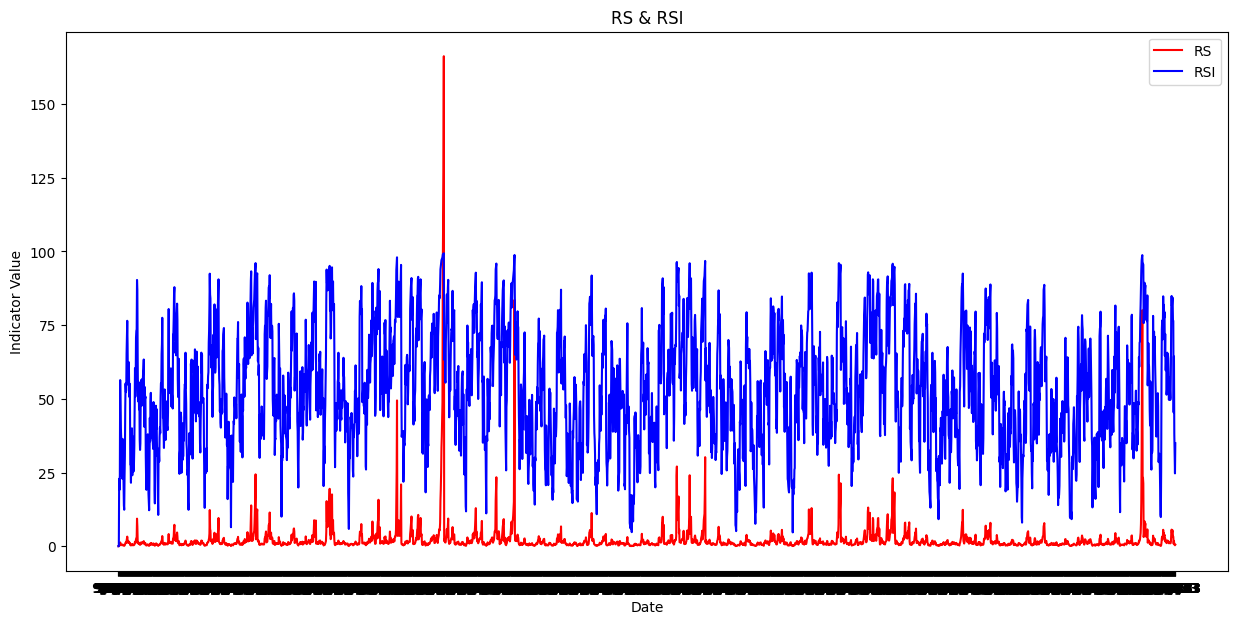

In [6]:
plt.figure(figsize=(15,7))
plt.plot(df['RS'],'r',label="RS")
plt.plot(df['RSI'], 'b', label="RSI")
plt.title("RS & RSI")
plt.ylabel("Indicator Value")
plt.xlabel("Date")
plt.legend()
plt.show()

### Calculating MACD

In [7]:
macd = sdf.get('macd')
df['MACD'] = macd
macd_s = sdf.get('macds')
df['MACD_signal'] = macd_s
macd_h = sdf.get('macdh')
df['MACD_histogram'] = macd_h

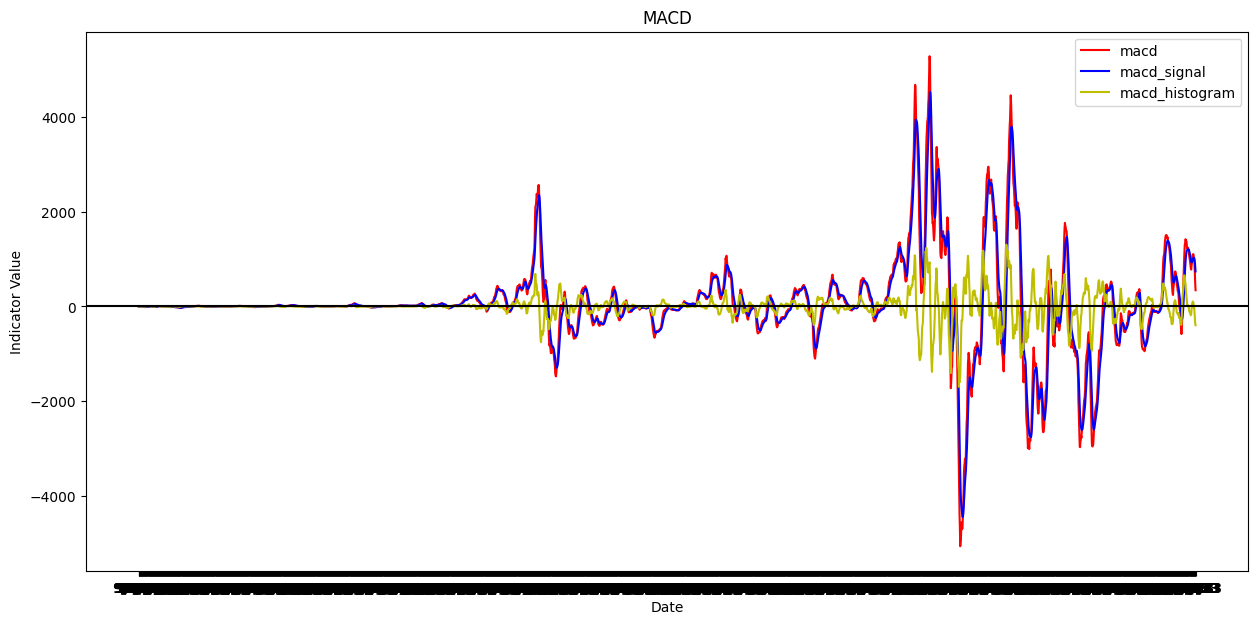

In [8]:
plt.figure(figsize=(15,7))
plt.plot(df['MACD'],'r',label="macd")
plt.plot(df['MACD_signal'], 'b', label="macd_signal")
plt.plot(df['MACD_histogram'], 'y', label="macd_histogram")
plt.axhline(y=0, color='black')
plt.title("MACD")
plt.ylabel("Indicator Value")
plt.xlabel("Date")
plt.legend()
plt.show()

### Bollinger Bands

In [9]:
#Bollinger Bands Middle, Upper, Lower
bbs_m= sdf.get('boll')
bbs_u= sdf.get('boll_ub')
bbs_l=sdf.get('boll_lb')

df['BB_Upper'] = bbs_u
df['BB_Mid'] = bbs_m
df['BB_Low'] = bbs_l

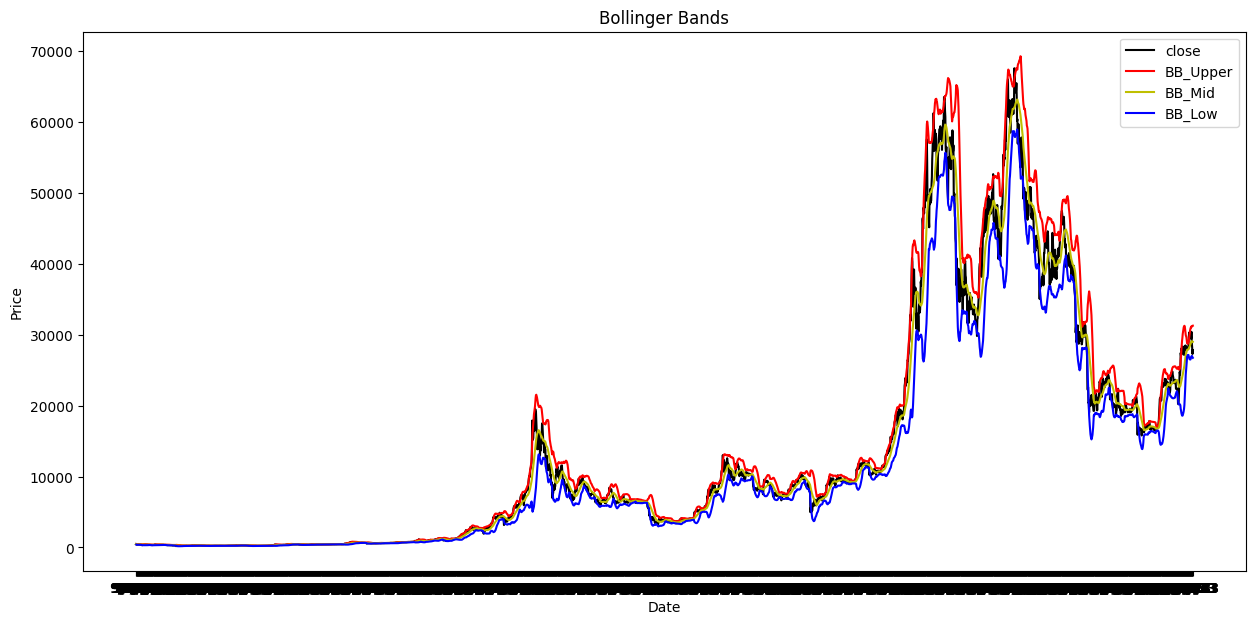

In [10]:
plt.figure(figsize=(15,7))
plt.plot(df['close'], 'black', label="close")
plt.plot(df['BB_Upper'],'r',label="BB_Upper")
plt.plot(df['BB_Mid'], 'y', label="BB_Mid")
plt.plot(df['BB_Low'], 'b', label="BB_Low")
plt.title("Bollinger Bands")
plt.ylabel("Price")
plt.xlabel("Date")
plt.legend()
plt.show()

## Oranizing the data

In [11]:
df = df.dropna()
new_order = ['open', 'RSI', 'RS', 'MACD', 'MACD_signal', 'MACD_histogram', 'BB_Upper', 'BB_Mid', 'BB_Low', 'close']
df = df.reindex(columns=new_order)

In [12]:
df

,open,RSI,RS,MACD,MACD_signal,MACD_histogram,BB_Upper,BB_Mid,BB_Low,close
date,,,,,,,,,,
9/18/14,456.859985,0.000000,0.000000,-0.738007,-0.410004,-0.328003,487.406168,440.887008,394.367849,424.440002
9/19/14,424.102997,0.000000,0.000000,-1.859626,-1.004111,-0.855515,488.089504,425.523336,362.957167,394.795990
9/20/14,394.673004,22.882389,0.296721,-1.814822,-1.278742,-0.536080,475.088945,421.368500,367.648055,408.903992
9/21/14,408.084991,19.128461,0.236529,-2.153494,-1.538961,-0.614533,467.565274,416.859003,366.152731,398.821014
9/22/14,399.100006,24.066818,0.316947,-2.174168,-1.711138,-0.463031,461.323696,414.407837,367.491977,402.152008
...,...,...,...,...,...,...,...,...,...,...
4/18/23,29449.091800,64.400709,1.809045,996.967633,1020.445566,-23.477932,31179.228064,29044.891894,26910.555725,30397.552730
4/19/23,30394.187500,38.097413,0.615441,855.393393,987.435131,-132.041738,31168.552134,29084.347754,27000.143374,28822.679690
4/20/23,28823.683590,32.300373,0.477113,688.721458,927.692396,-238.970939,31173.681927,29072.722949,26971.763971,28245.988280


## Dataset Summary

In [13]:
df_chart = df.copy()

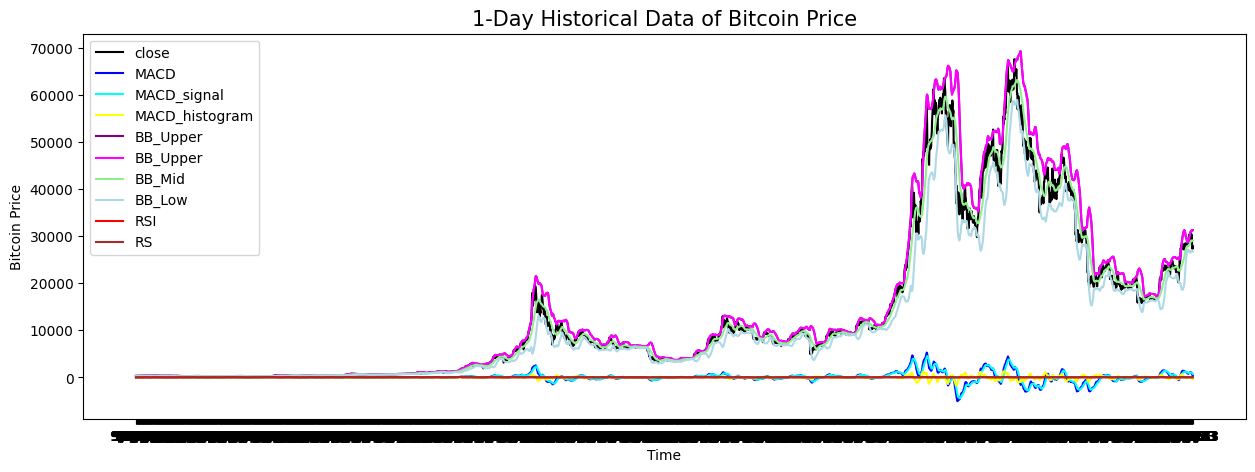

In [14]:
plt.figure(figsize=(15,5))
plt.plot(df_chart.index, df_chart['close'], color='black', label='close')
plt.plot(df_chart.index, df_chart['MACD'], color='blue', label='MACD')
plt.plot(df_chart.index, df_chart['MACD_signal'], color='cyan', label='MACD_signal')
plt.plot(df_chart.index, df_chart['MACD_histogram'], color='yellow', label='MACD_histogram')
plt.plot(df_chart.index, df_chart['BB_Upper'], color='purple', label='BB_Upper')
plt.plot(df_chart.index, df_chart['BB_Upper'], color='magenta', label='BB_Upper')
plt.plot(df_chart.index, df_chart['BB_Mid'], color='lightgreen', label='BB_Mid')
plt.plot(df_chart.index, df_chart['BB_Low'], color='lightblue', label='BB_Low')
plt.plot(df_chart.index, df_chart['RSI'], color='red', label='RSI')
plt.plot(df_chart.index, df_chart['RS'], color='brown', label='RS')
plt.title('1-Day Historical Data of Bitcoin Price', fontsize=15)
plt.ylabel('Bitcoin Price')
plt.xlabel('Time')
plt.legend()


plt.show()

## Data featuring

In [15]:
del df['RSI']
del df['RS']
df

,open,MACD,MACD_signal,MACD_histogram,BB_Upper,BB_Mid,BB_Low,close
date,,,,,,,,
9/18/14,456.859985,-0.738007,-0.410004,-0.328003,487.406168,440.887008,394.367849,424.440002
9/19/14,424.102997,-1.859626,-1.004111,-0.855515,488.089504,425.523336,362.957167,394.795990
9/20/14,394.673004,-1.814822,-1.278742,-0.536080,475.088945,421.368500,367.648055,408.903992
9/21/14,408.084991,-2.153494,-1.538961,-0.614533,467.565274,416.859003,366.152731,398.821014
9/22/14,399.100006,-2.174168,-1.711138,-0.463031,461.323696,414.407837,367.491977,402.152008
...,...,...,...,...,...,...,...,...
4/18/23,29449.091800,996.967633,1020.445566,-23.477932,31179.228064,29044.891894,26910.555725,30397.552730
4/19/23,30394.187500,855.393393,987.435131,-132.041738,31168.552134,29084.347754,27000.143374,28822.679690
4/20/23,28823.683590,688.721458,927.692396,-238.970939,31173.681927,29072.722949,26971.763971,28245.988280


In [16]:
feature_df = df.iloc[:,0:df.shape[1]]

scaler = MinMaxScaler(feature_range = (0,1))

scaled_features = scaler.fit_transform(feature_df.iloc[:,0:df.shape[1]-1].values)
scaled_targets = scaler.fit_transform(feature_df.iloc[:,df.shape[1]-1:df.shape[1]].values)

df_ft = pd.DataFrame(columns=feature_df.columns[0:df.shape[1]-1],
                         data=scaled_features,
                         index=feature_df.index)

df_y = pd.DataFrame(columns=feature_df.columns[df.shape[1]-1:df.shape[1]],
                         data=scaled_targets,
                         index=feature_df.index)

In [17]:
df_ft

,open,MACD,MACD_signal,MACD_histogram,BB_Upper,BB_Mid,BB_Low
date,,,,,,,
9/18/14,0.004155,0.489251,0.495594,0.564762,0.003600,0.003409,0.003818
9/19/14,0.003669,0.489142,0.495528,0.564586,0.003610,0.003165,0.003284
9/20/14,0.003232,0.489147,0.495497,0.564692,0.003421,0.003099,0.003363
9/21/14,0.003431,0.489114,0.495468,0.564666,0.003312,0.003027,0.003338
9/22/14,0.003298,0.489112,0.495449,0.564717,0.003222,0.002988,0.003361
...,...,...,...,...,...,...,...
4/18/23,0.434481,0.585862,0.609578,0.557045,0.448272,0.457997,0.455059
4/19/23,0.448509,0.572153,0.605892,0.520855,0.448117,0.458624,0.456583
4/20/23,0.425198,0.556013,0.599222,0.485210,0.448191,0.458439,0.456100


In [18]:
df_y

,close
date,
9/18/14,0.003655
9/19/14,0.003216
9/20/14,0.003425
9/21/14,0.003275
9/22/14,0.003325
...,...
4/18/23,0.448435
4/19/23,0.425065
4/20/23,0.416507


In [19]:
def lstm_split(data, target, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps + 1):
        X.append(data[i:i + n_steps, 0:df.shape[1]-1])
        y.append(target[i:i+1, -1])
    return np.array(X), np.array(y)

def lstm_split2(data, n_steps):
    X = []
    for i in range(len(data) - n_steps + 1):
        X.append(data[i:i + n_steps, 0:df2.shape[1]-1])
    return np.array(X)

In [20]:
n_steps = 100
X1, y1 = lstm_split(df_ft.values, df_y.values, n_steps)

In [21]:
print(X1.shape, y1.shape)

(3040, 100, 7) (3040, 1)


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.3, random_state=42)

In [23]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2128, 100, 7) (2128, 1) (912, 100, 7) (912, 1)


## LSTM model

In [24]:
model = Sequential ()
model. add(LSTM(units = 100, return_sequences= True, input_shape = (X_train.shape[1], X_train.shape[2])))
model. add (Dropout (0.2))
model. add (LSTM(units = 50, return_sequences= True))
model. add (Dropout (0.2))
model. add(LSTM(units = 100, return_sequences= True))
model. add(Dropout (0.2))
model.add(LSTM(units = 50))
model.add(Dropout (0.2))
model.add(Dense (units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

Metal device set to: Apple M2


## model Summary

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 100)          43200     
                                                                 
 dropout (Dropout)           (None, 100, 100)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           30200     
                                                                 
 dropout_1 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 100)          60400     
                                                                 
 dropout_2 (Dropout)         (None, 100, 100)          0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                3

In [26]:
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50


2023-04-23 18:15:22.433553: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


67/67 [==============================] - 6s 40ms/step - loss: 0.0076
Epoch 2/50
67/67 [==============================] - 2s 35ms/step - loss: 0.0026
Epoch 3/50
67/67 [==============================] - 2s 36ms/step - loss: 0.0016
Epoch 4/50
67/67 [==============================] - 2s 37ms/step - loss: 0.0016
Epoch 5/50
67/67 [==============================] - 2s 36ms/step - loss: 0.0014
Epoch 6/50
67/67 [==============================] - 2s 37ms/step - loss: 0.0011
Epoch 7/50
67/67 [==============================] - 2s 36ms/step - loss: 8.1941e-04
Epoch 8/50
67/67 [==============================] - 2s 35ms/step - loss: 0.0011
Epoch 9/50
67/67 [==============================] - 2s 35ms/step - loss: 7.2385e-04
Epoch 10/50
67/67 [==============================] - 2s 35ms/step - loss: 8.6625e-04
Epoch 11/50
67/67 [==============================] - 2s 35ms/step - loss: 8.3681e-04
Epoch 12/50
67/67 [==============================] - 2s 36ms/step - loss: 7.8150e-04
Epoch 13/50
67/67 [=========

## Evaluate

In [27]:
y_pred = model.predict(X_test)

29/29 [==============================] - 1s 15ms/step


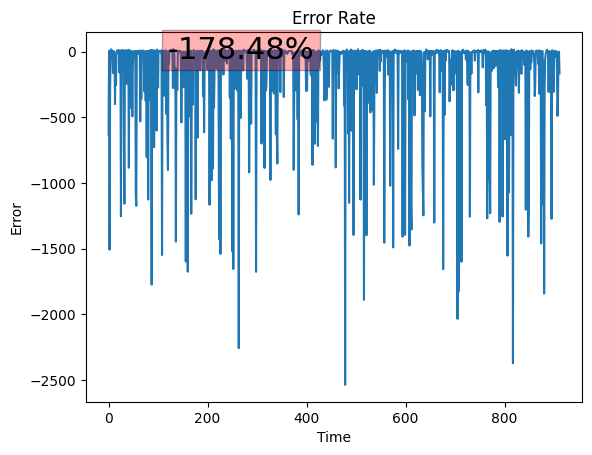

In [28]:
error_rates = (y_test.reshape(-1, 1) - y_pred) / y_test.reshape(-1, 1) * 100
average_error_rate = np.sum(error_rates)/len(error_rates)
plt.plot(error_rates)
plt.text(120,-55, f'{average_error_rate:.2f}%', fontsize = 22, bbox = dict(facecolor = 'red', alpha = 0.3))
plt.title('Error Rate')
plt.xlabel('Time')
plt.ylabel('Error')
plt.show()

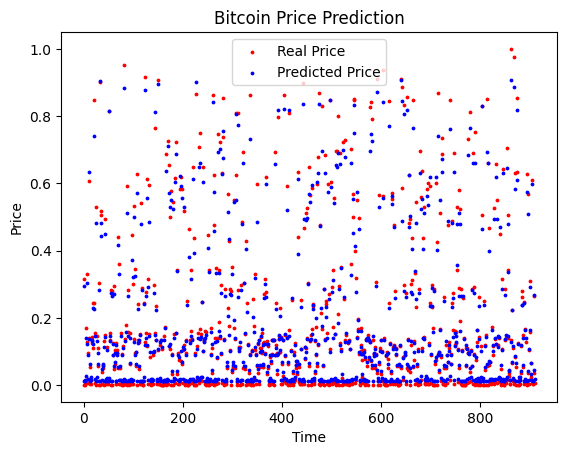

In [29]:
y_test_index = range(len(y_test))

y_test_series = pd.Series(y_test.reshape(-1,), index=y_test_index)
y_pred_series = pd.Series(y_pred.reshape(-1,), index=y_test_index)

plt.scatter(y_test_series.index, y_test_series, color='red', label='Real Price', s=3)
plt.scatter(y_pred_series.index, y_pred_series, color='blue', label='Predicted Price', s=3)
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

## Remove Scaling

In [30]:
print(y_test.shape, y_pred.shape)

(912, 1) (912, 1)


In [31]:
y_test_original = scaler.inverse_transform(y_test)

In [32]:
y_test_original

array([[  292.053986],
       [21528.08789 ],
       [  226.852997],
       [  407.707001],
       [ 1229.079956],
       [11573.29981 ],
       [ 8716.790039],
       [22485.68945 ],
       [ 6596.540039],
       [  610.684021],
       [41034.54297 ],
       [ 9663.181641],
       [ 3810.42749 ],
       [  357.839996],
       [ 1272.829956],
       [  455.653015],
       [ 8693.833008],
       [ 9743.860352],
       [ 7707.770996],
       [16687.51758 ],
       [57229.82813 ],
       [16604.46484 ],
       [  636.786011],
       [10709.65234 ],
       [35867.77734 ],
       [  236.822998],
       [ 1080.5     ],
       [10070.39258 ],
       [ 4032.507324],
       [ 7511.588867],
       [20595.35156 ],
       [  286.393005],
       [  242.712997],
       [61004.40625 ],
       [34240.1875  ],
       [35040.83594 ],
       [ 2809.01001 ],
       [  462.321991],
       [ 3648.430664],
       [ 4161.27002 ],
       [ 9078.762695],
       [  261.550995],
       [10141.99609 ],
       [335

In [33]:
y_pred_original = scaler.inverse_transform(y_pred)

In [34]:
y_pred_original

array([[ 1010.56494],
       [20056.41   ],
       [  961.83936],
       [ 1140.2649 ],
       [ 1921.0702 ],
       [ 9520.21   ],
       [ 8315.252  ],
       [20542.557  ],
       [ 6177.4116 ],
       [ 1316.9308 ],
       [42798.28   ],
       [ 9470.99   ],
       [ 4393.8027 ],
       [ 1075.0496 ],
       [ 1890.9082 ],
       [ 1158.6685 ],
       [ 9206.568  ],
       [ 8937.601  ],
       [ 8372.896  ],
       [15717.125  ],
       [50068.24   ],
       [15348.04   ],
       [ 1363.9608 ],
       [10014.123  ],
       [32730.426  ],
       [  972.7759 ],
       [ 1776.5463 ],
       [ 8991.732  ],
       [ 4430.9004 ],
       [ 6697.914  ],
       [19226.586  ],
       [ 1007.1451 ],
       [  991.0273 ],
       [61207.73   ],
       [30126.566  ],
       [32629.064  ],
       [ 3487.8572 ],
       [ 1157.6986 ],
       [ 3983.2449 ],
       [ 4397.44   ],
       [ 7806.428  ],
       [  999.18115],
       [ 9802.259  ],
       [30372.287  ],
       [ 1332.7985 ],
       [ 1

## Predicting Today's closing price
## To predict today's price, you need to download the n_step previous data

In [35]:
df2 = pd.read_csv("../DataSets/BTC-USD2.csv")
df2 = df2.dropna()
del df2['High']
del df2['Low']
del df2['Adj Close']
del df2['Volume']

In [36]:
df2

,Date,Open,Close
0,2023-01-13,18868.906250,19909.574219
1,2023-01-14,19910.537109,20976.298828
2,2023-01-15,20977.484375,20880.798828
3,2023-01-16,20882.224609,21169.632813
4,2023-01-17,21175.833984,21161.519531
...,...,...,...
95,2023-04-18,29449.091797,30397.552734
96,2023-04-19,30394.187500,28822.679688
97,2023-04-20,28823.683594,28245.988281
98,2023-04-21,28249.230469,27276.910156


In [62]:
Open = 27804.27
TODAY = pd.DataFrame({'Date': ['2023-04-23'], 
                            'Open': [Open], 
                            'Close': [np.nan]})

In [63]:
TODAY

,Date,Open,Close
0,2023-04-23,27804.27,NaN


In [39]:
df2 = pd.concat([df2, TODAY], ignore_index=True)

In [40]:
sdf2 = StockDataFrame.retype(df2)
sdf2

,open,close
date,,
2023-01-13,18868.906250,19909.574219
2023-01-14,19910.537109,20976.298828
2023-01-15,20977.484375,20880.798828
2023-01-16,20882.224609,21169.632813
2023-01-17,21175.833984,21161.519531
...,...,...
2023-04-19,30394.187500,28822.679688
2023-04-20,28823.683594,28245.988281
2023-04-21,28249.230469,27276.910156


In [41]:
macd = sdf2.get('macd')
df2['MACD'] = macd
macd_s = sdf2.get('macds')
df2['MACD_signal'] = macd_s
macd_h = sdf2.get('macdh')
df2['MACD_histogram'] = macd_h
bbs_m= sdf2.get('boll')
bbs_u= sdf2.get('boll_ub')
bbs_l=sdf2.get('boll_lb')
df2['BB_Upper'] = bbs_u
df2['BB_Mid'] = bbs_m
df2['BB_Low'] = bbs_l

In [42]:
df2.shape[0]

101

In [43]:
new_order2 = ['open', 'MACD', 'MACD_signal', 'MACD_histogram', 'BB_Upper', 'BB_Mid', 'BB_Low', 'close']
df2 = df2.iloc[1:df2.shape[0],:]
df2 = df2.reindex(columns=new_order2)
df2

,open,MACD,MACD_signal,MACD_histogram,BB_Upper,BB_Mid,BB_Low,close
date,,,,,,,,
2023-01-14,19910.537109,23.932924,13.296069,10.636855,21951.512933,20442.936524,18934.360114,20976.298828
2023-01-15,20977.484375,27.533846,19.131223,8.402623,21769.370438,20588.890625,19408.410812,20880.798828
2023-01-16,20882.224609,38.925073,25.836457,13.088616,21859.368674,20734.076172,19608.783670,21169.632813
2023-01-17,21175.833984,43.972578,31.231543,12.741035,21866.407082,20819.564844,19772.722606,21161.519531
2023-01-18,21161.050781,25.965709,29.804209,-3.838500,21740.161252,20797.767578,19855.373905,20688.781250
...,...,...,...,...,...,...,...,...
2023-04-19,30394.187500,848.780534,978.375987,-129.595454,31168.552136,29084.347754,27000.143372,28822.679688
2023-04-20,28823.683594,682.615873,919.223964,-236.608091,31173.681929,29072.722949,26971.763970,28245.988281
2023-04-21,28249.230469,467.380859,828.855343,-361.474484,31249.231841,29016.016699,26782.801557,27276.910156


In [54]:
feature_df2 = df2.iloc[:,0:df2.shape[1]]

scaler = MinMaxScaler(feature_range = (0,1))

scaled_features2 = scaler.fit_transform(feature_df2.iloc[:,0:df2.shape[1]-1].values)
scaled_targets2 = scaler.fit_transform(feature_df2.iloc[:,df2.shape[1]-1:df2.shape[1]].values)

df_ft2 = pd.DataFrame(columns=feature_df2.columns[0:df2.shape[1]-1],
                         data=scaled_features2,
                         index=feature_df2.index)

df_y2 = pd.DataFrame(columns=feature_df2.columns[df2.shape[1]-1:df2.shape[1]],
                         data=scaled_targets2,
                         index=feature_df2.index)

In [55]:
df_ft2 = df_ft2.dropna()
df_ft2

,open,MACD,MACD_signal,MACD_histogram,BB_Upper,BB_Mid,BB_Low
date,,,,,,,
2023-01-14,0.000000,0.329457,0.243404,0.397825,0.023341,0.000000,0.042376
2023-01-15,0.100844,0.331236,0.247196,0.395782,0.004434,0.016890,0.097708
2023-01-16,0.091840,0.336864,0.251554,0.400067,0.013776,0.033691,0.121095
2023-01-17,0.119591,0.339358,0.255060,0.399749,0.014507,0.043584,0.140230
2023-01-18,0.118194,0.330461,0.254132,0.384589,0.001402,0.041062,0.149877
...,...,...,...,...,...,...,...
2023-04-19,0.990873,0.737025,0.870585,0.269595,0.980094,1.000000,0.983818
2023-04-20,0.842435,0.654921,0.832144,0.171741,0.980627,0.998655,0.980506
2023-04-21,0.788140,0.548570,0.773415,0.057562,0.988469,0.992093,0.958450


In [56]:
X2 = lstm_split2(df_ft2.values, n_steps)

In [57]:
X2.shape

(1, 100, 7)

In [58]:
y_today = model.predict(X2)

1/1 [==============================] - 0s 54ms/step


In [59]:
y_today.shape

(1, 1)

In [60]:
y_today_original = scaler.inverse_transform(y_today)

In [73]:
y_today_original

array([[24438.682]], dtype=float32)

In [74]:
Today = y_today_original.astype(np.float32)

## Fee calculating
based on biance trading fees(0.1%)

In [94]:
buying_fee = Open * 0.001
selling_fee = Today * 0.001
fees = buying_fee + selling_fee
if (Open > Today + fees):
    print("stay")
elif (Open > Today + fees):
    print("You can earn money today: ", ((Today + fees)-Open)/Open*100, "%")

stay
